# Auto Arima

In [13]:
# Carregar Bibliotecas
library(dplyr)
library(xts)
library(ggplot2)
library(forecast)
library(tidyverse)

In [2]:
path <- "https://raw.githubusercontent.com/E-man85/projectII/main/dataStaging/grainWeekMultipleVariables.csv"
df <- read.csv(path)
df <- df[, c('store_id','date', 'summed_revenue')]
rm(path)
head(df)
str(df)
dim(df)

,store_id,date,summed_revenue
,<chr>,<chr>,<dbl>
1,S0002,2017-01-08,1813.24
2,S0002,2017-01-15,1896.91
3,S0002,2017-01-22,7404.16
4,S0002,2017-01-29,2078.39
5,S0002,2017-02-05,1745.47
6,S0002,2017-02-12,2235.39


'data.frame':	8301 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : chr  "2017-01-08" "2017-01-15" "2017-01-22" "2017-01-29" ...
 $ summed_revenue: num  1813 1897 7404 2078 1745 ...


[1] 8301    3

## Data Preparation

In [3]:
# Alterar tipo da coluna date
df$date <- as.Date(df$date)
# criar variável com lista das lojas unicas
stores <- unique(df$store_id)
# Lista para armazenar os dataframes
df_list <- list()
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store <- df[df$store_id == store,]
  # Adicionar dataframe à lista
  df_list[[store]] <- df_store
}
# Dividir dados treino e teste
# lista para armazenar os timeseries teste e treino
df_train <- list()
df_test <- list()
# Loop para criar as séries temporais semanais e armazenar nas lista
for (t in names(df_list)) {
  data <- df_list[[t]]
  train <- head(data, -5)
  test <- tail(data, 5)
  df_train[[t]] <- train
  df_test[[t]] <- test
}
# Converter em timeseries ts
# lista para armazenar os timeseries 
ts_real <- list()
ts_train <- list()
ts_test <- list()
# Loop
for(t in names(df_list)){
    data <- df_list[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_real[[t]] <- ts
}
# Loop
for(t in names(df_train)){
    data <- df_train[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_train[[t]] <- ts
}
# Loop
for(t in names(df_test)){
    data <- df_test[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_test[[t]] <- ts
}
length(ts_train)
length(ts_test)
length(ts_real)


[1] 63

[1] 63

[1] 63

## Models AutoArima & Sarima

In [4]:
# Modelo auto arima
forecast_values <- list() # armazena valores de previsões
models_arima <- list() # armazena modelos
forecast_models <- list()# armazena precict dos modelos
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    model_arima <- auto.arima(data)
    models_arima[[ts]] <- model_arima
    forecast_arima <- forecast(model_arima, h = 5) # fazer previsões de 5 periodos
    forecast_models[[ts]] <- forecast_arima
    forecast_values[[ts]] <- round(forecast_arima$mean,2)
}
# Modelo Sarima
forecast_s_values <- list() # armazena valores de previsões
models_sarima <- list() # armazena modelos
forecast_smodels <- list()# armazena precict dos modelos
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    model_sarima <- auto.arima(data, 
                        seasonal = TRUE,
                        stepwise=FALSE, #todas as combinações possíveis de parâmetros serão avaliadas durante a seleção do modelo
                        approximation=FALSE) #não fará aproximações para acelerar o processo de ajuste
    models_sarima[[ts]] <- model_sarima
    forecast_sarima <- forecast(model_sarima, h = 5) # fazer previsões de 5 periodos
    forecast_smodels[[ts]] <- forecast_sarima
    forecast_s_values[[ts]] <- round(forecast_sarima$mean,2)
}
length(forecast_values)
length(forecast_s_values)

[1] 63

[1] 63

### Visualizar informações sobre os modelos Auto-Arima e Sarima

In [5]:
# Ex : Loja 'S0003'
# Visualize as informações do modelo
summary(models_arima[['S0003']])
summary(models_sarima[['S0003']])

Series: data 
ARIMA(1,1,1) 

Coefficients:
         ar1      ma1
      0.2187  -0.8809
s.e.  0.1634   0.0870

sigma^2 = 246417:  log likelihood = -1044.36
AIC=2094.72   AICc=2094.9   BIC=2103.48

Training set error measures:
                   ME     RMSE      MAE      MPE    MAPE      MASE
Training set 54.32259 490.9785 199.2222 -3.13276 18.4002 0.5141381
                      ACF1
Training set -0.0005664751

Series: data 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.7912
s.e.   0.1301

sigma^2 = 247833:  log likelihood = -1045.19
AIC=2094.38   AICc=2094.47   BIC=2100.22

Training set error measures:
                   ME    RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 49.93452 494.208 197.2965 -3.644815 18.28209 0.5091685 0.04725968

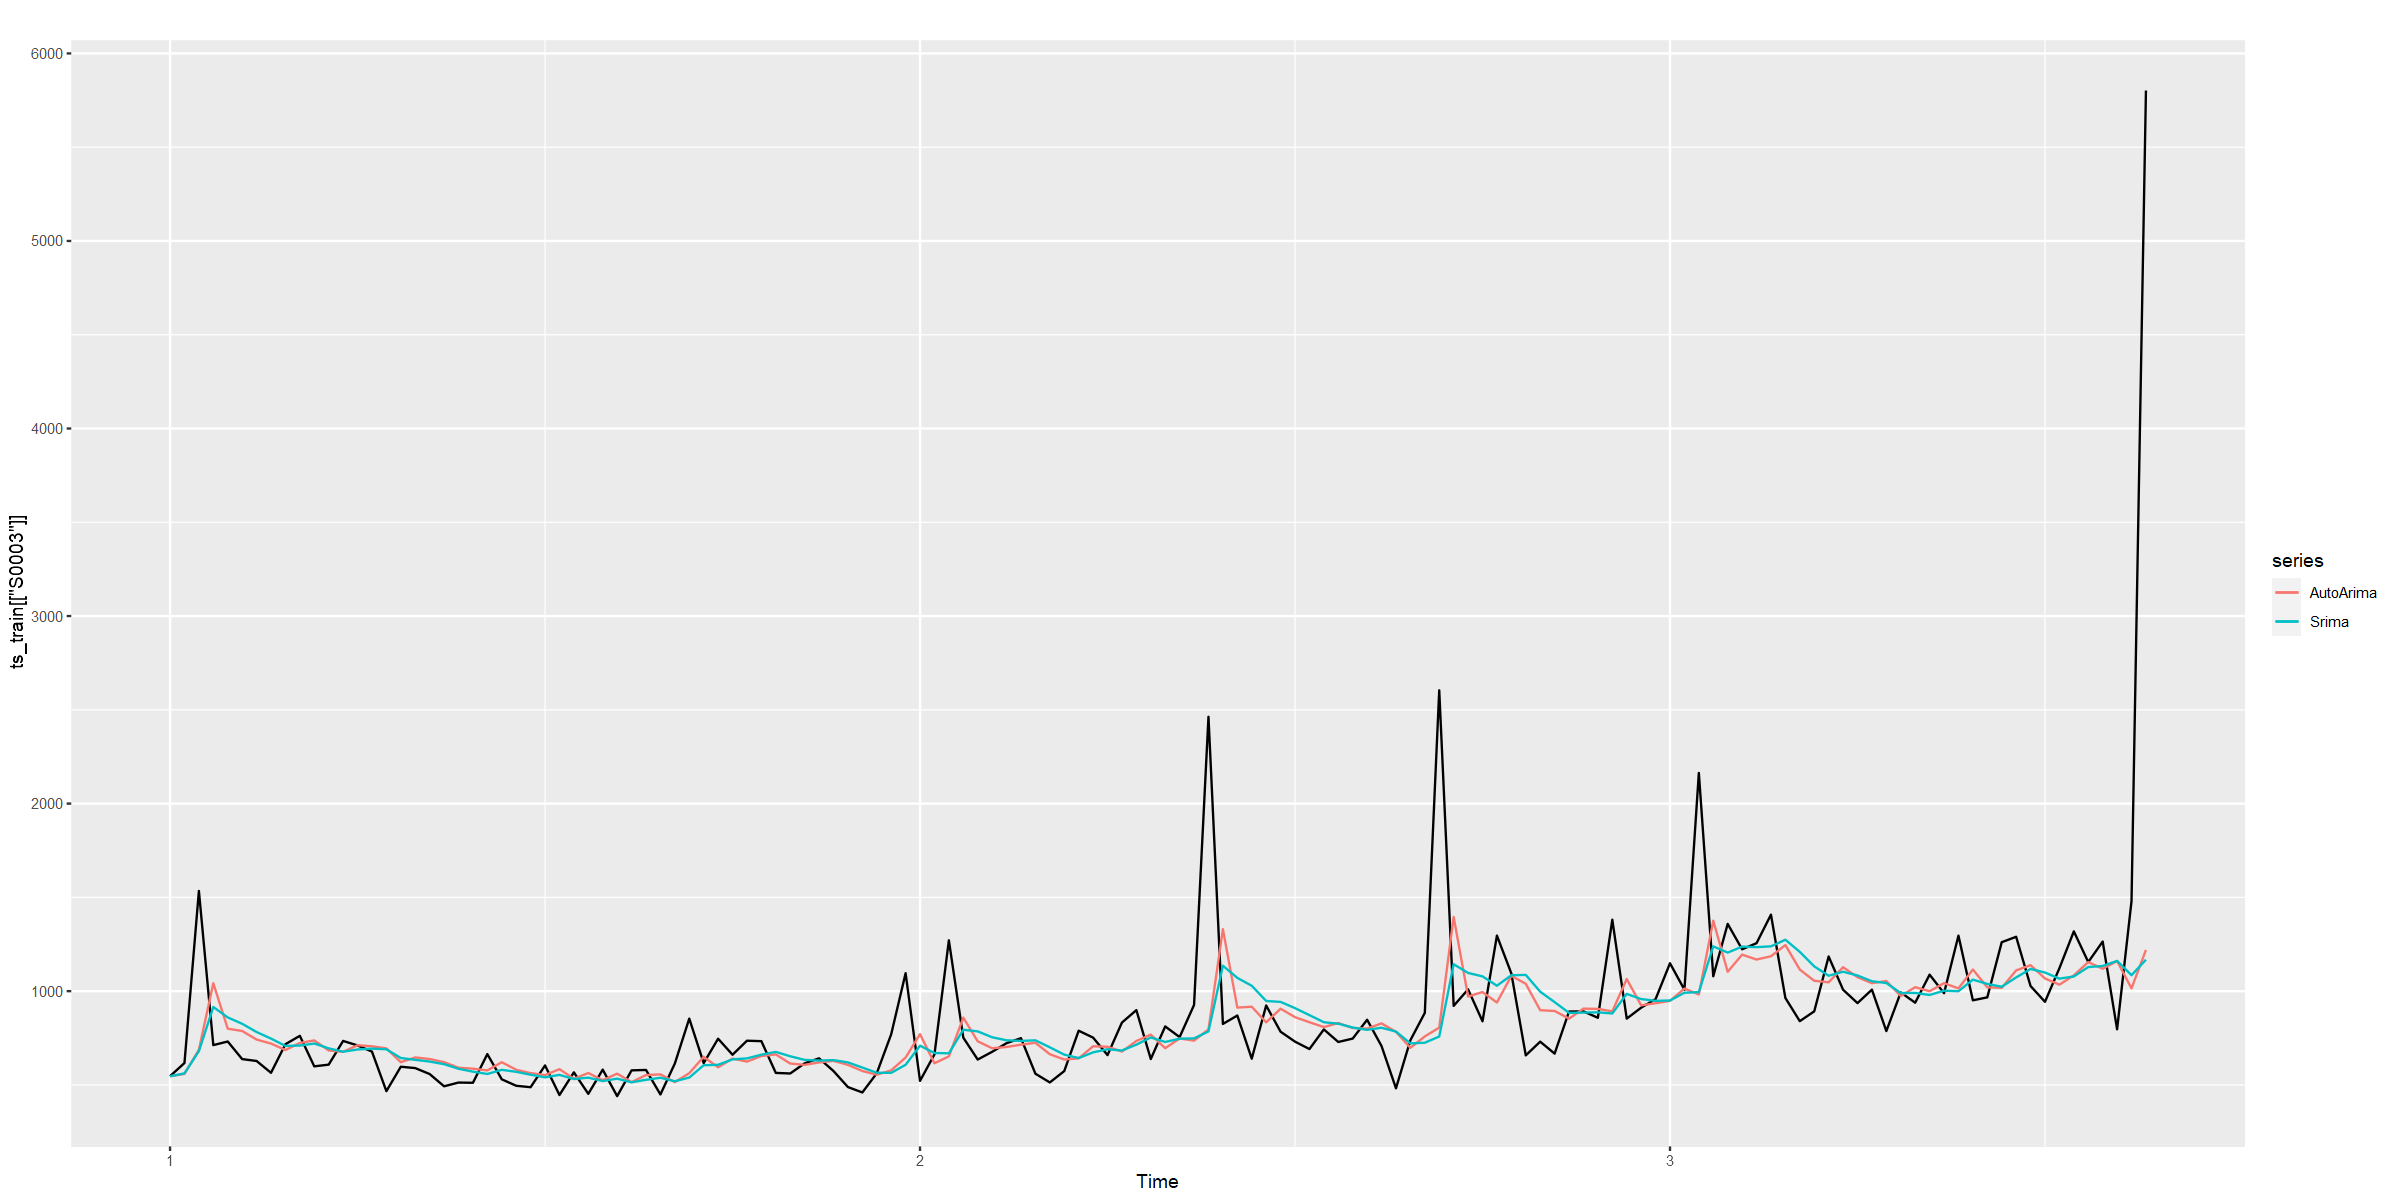

In [6]:
# Ver os valores reais VS valores ajustados pelo modelo
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,2))
autoplot(ts_train[['S0003']])+
autolayer(models_arima[['S0003']]$fitted, series = "AutoArima")+
autolayer(models_sarima[['S0003']]$fitted, series = "Srima")


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 8.677, df = 26, p-value = 0.9994

Model df: 2.   Total lags used: 28



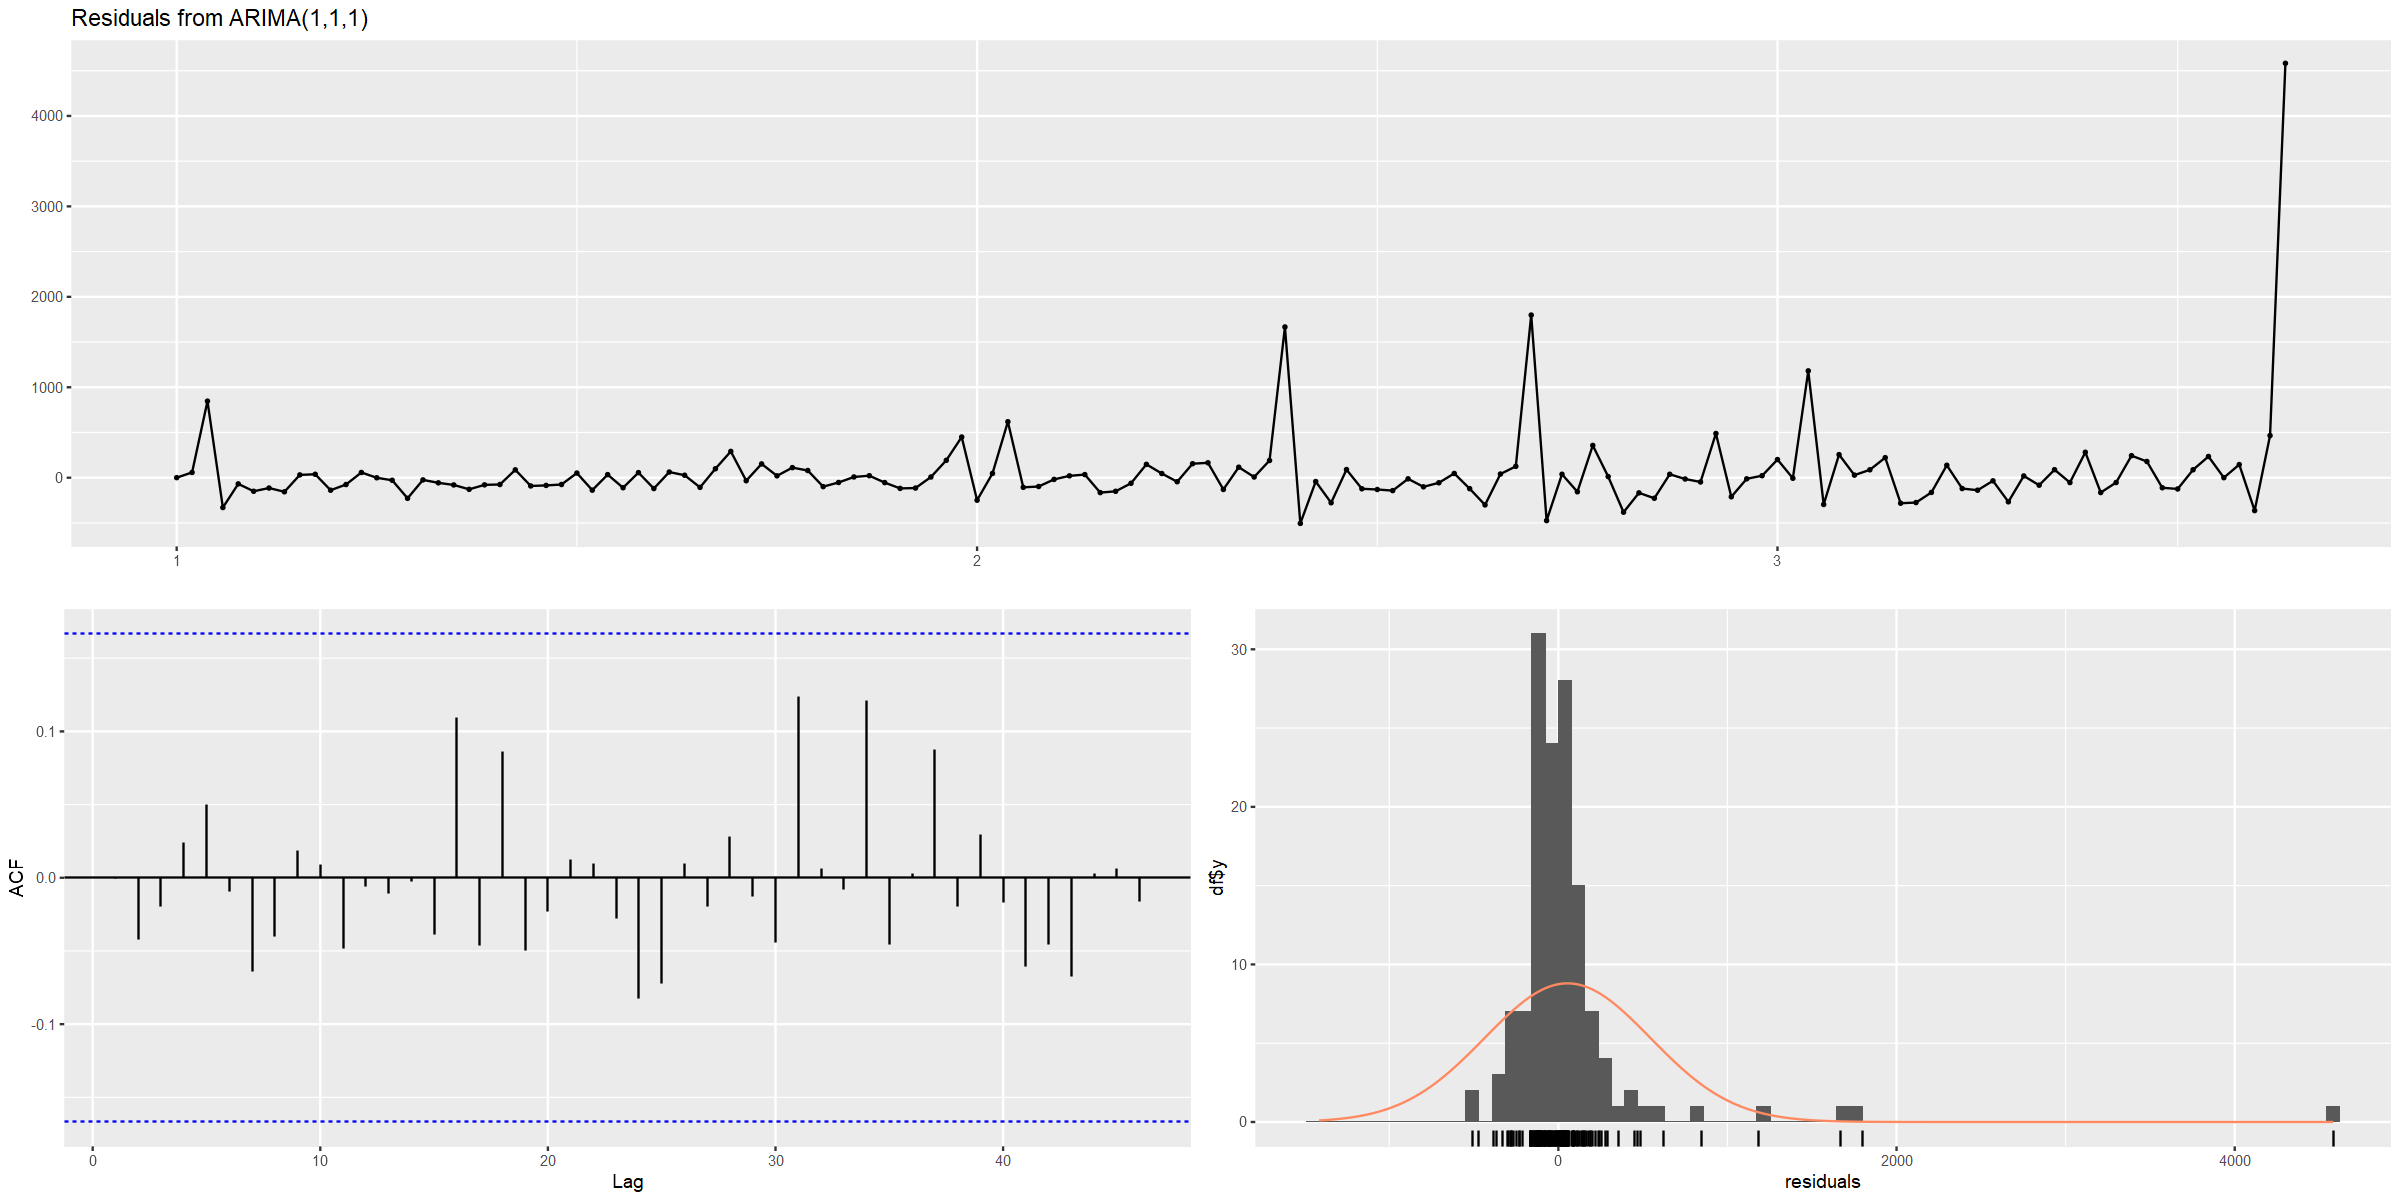


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 9.9579, df = 27, p-value = 0.9988

Model df: 1.   Total lags used: 28



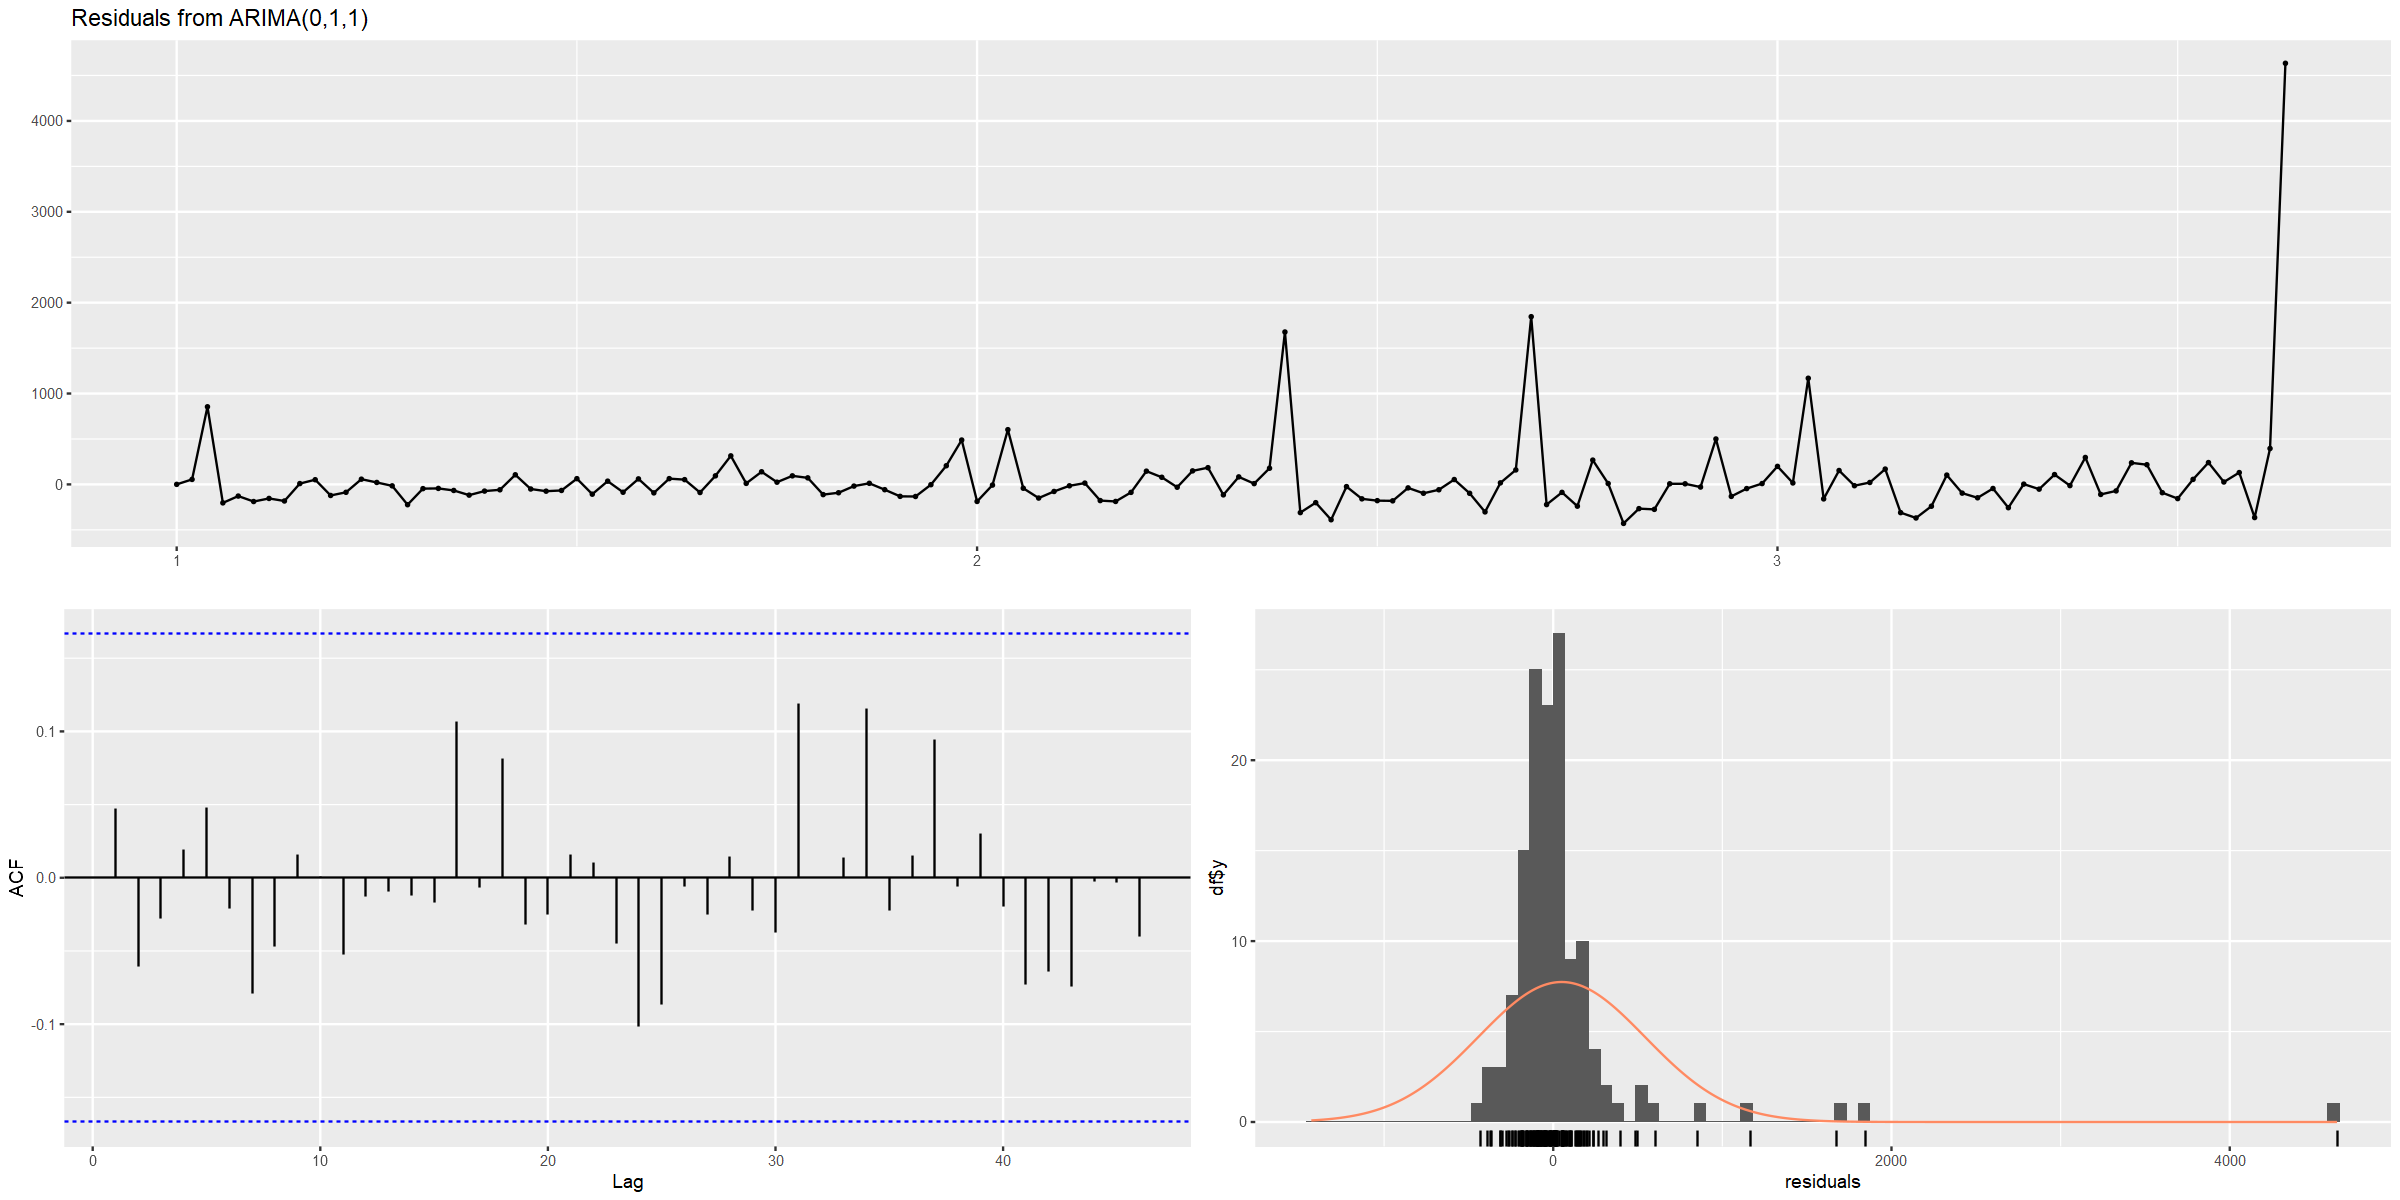

In [7]:
# Ver os resíduos do modelo
checkresiduals(models_arima[['S0003']])
checkresiduals(models_sarima[['S0003']])

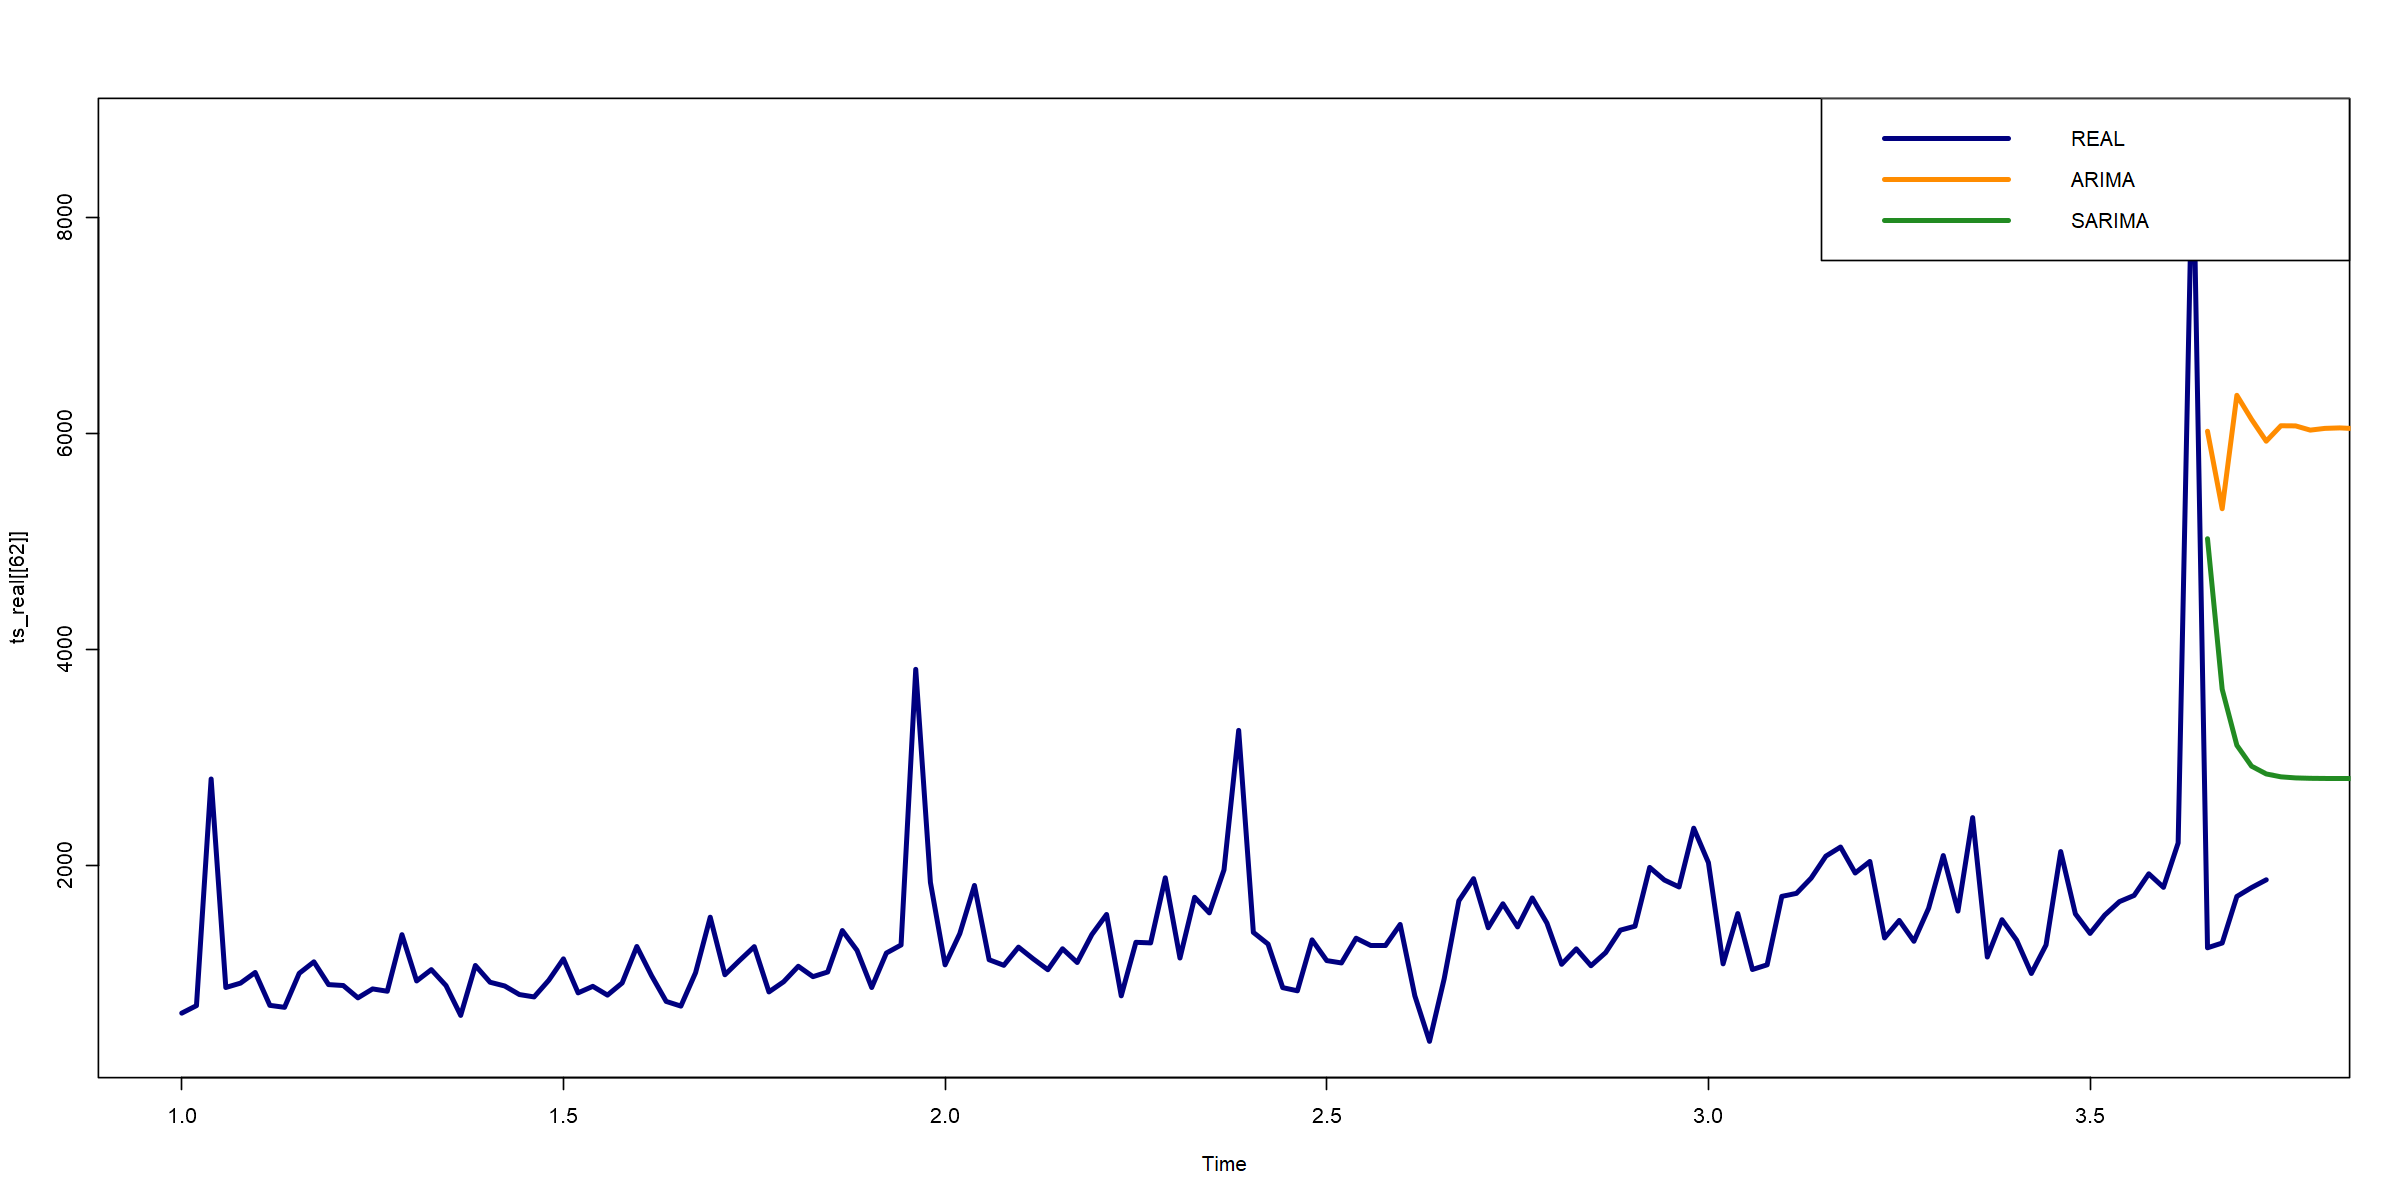

In [8]:
# Ver previsões ex: loja S0142
options(repr.plot.width = 20, repr.plot.height = 10)
# Obter as previsões dos modelos
predict_arima_model <- forecast(models_arima[[62]])
predict_sarima_model <- forecast(models_sarima[[62]])
# Plot das previsões
plot(ts_real[[62]], col = "navyblue", lwd = 3)
# Adicionar as previsões dos modelos arima e sarima 
lines(predict_arima_model$mean, col = "darkorange", lwd = 3)
lines(predict_sarima_model$mean, col = "forestgreen", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topright", legend = c("REAL",'ARIMA', "SARIMA"), col = c("navyblue", "darkorange","forestgreen"), lwd = 3)

### AIC E BIC Dos Modelos

In [9]:
# dataframe vazio
df_metrics_arima <- data.frame(store_id = character(),
                 Aic = numeric(),
                 Bic = numeric(),
                 stringsAsFactors = FALSE)
# Loop
for (i in 1:length(models_arima)) {
  #  nome do modelo
  nome_modelo <- names(models_arima[i])
  #  valor do AIC
  aic <- round(AIC(models_arima[[i]]),2)
  # valor do BIC
  bic <- round(BIC(models_arima[[i]]),2)
  # Adicione ao dataframe
  df_metrics_arima <- rbind(df_metrics_arima, data.frame(store_id = nome_modelo, Aic_arima = aic, Bic_arima = bic))
}
# dataframe vazio
df_metrics_sarima <- data.frame(store_id = character(),
                 Aic = numeric(),
                 Bic = numeric(),
                 stringsAsFactors = FALSE)

# Loop para modelos SARIMA
for (i in 1:length(models_sarima)) {
  # Nome do modelo
  nome_modelo <- names(models_sarima[i])
  # Valor do AIC
  aic <- round(AIC(models_sarima[[i]]), 2)
  # Valor do BIC
  bic <- round(BIC(models_sarima[[i]]), 2)
  # Adicionar ao dataframe
  df_metrics_sarima <- rbind(df_metrics_sarima, data.frame(store_id = nome_modelo, Aic_sarima = aic, Bic_sarima = bic))
}
# Fazer o merge dos dataframes usando a coluna store_id
df_merged <- merge(df_metrics_arima, df_metrics_sarima, by = "store_id")
head(df_merged)

,store_id,Aic_arima,Bic_arima,Aic_sarima,Bic_sarima
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,S0002,2428.31,2445.83,2423.16,2431.92
2,S0003,2094.72,2103.48,2094.38,2100.22
3,S0005,1362.41,1369.63,1362.41,1369.63
4,S0007,307.16,309.34,307.16,309.34
5,S0010,2175.47,2187.15,2169.92,2178.68
6,S0012,2089.99,2098.75,2083.42,2100.94


## Predictions

In [10]:
#criar dataframe com resultados reais
prev <- do.call(rbind, df_test)
# Inserir o nome dos dataframes como uma coluna chamada "store_id"
prev$store_id <- rep(names(df_test), sapply(df_test, nrow))
# criar dataframe com os resultados autoarima
result <- do.call(rbind, forecast_values)
store_id <-names(forecast_values)
# Combinação do índice com a matriz
result_aarima <- data.frame(store_id = store_id, result)
result_aarima <- result_aarima %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "aarima_revenue")
# criar dataframe com os resultados sarima
result <- do.call(rbind, forecast_s_values)
store_id <-names(forecast_s_values)
# Combinação do índice com a matriz
result_sarima <- data.frame(store_id = store_id, result)
result_sarima <- result_sarima %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "sarima_revenue")
# juntar resultados num dataframe prev
prev$result_aarima <- result_aarima$aarima_revenue
prev$result_sarima <- result_sarima$sarima_revenue
head(prev,10)

,store_id,date,summed_revenue,result_aarima,result_sarima
,<chr>,<date>,<dbl>,<dbl>,<dbl>
S0002.139,S0002,2019-09-01,4164.56,10503.54,10274.14
S0002.140,S0002,2019-09-08,6267.91,6794.97,6007.38
S0002.141,S0002,2019-09-15,5007.57,6817.04,6007.38
S0002.142,S0002,2019-09-22,3074.56,5833.25,6007.38
S0002.143,S0002,2019-09-29,5728.25,5991.05,6007.38
S0003.282,S0003,2019-09-01,1030.02,2710.39,2135.01
S0003.283,S0003,2019-09-08,1302.61,2034.40,2135.01
S0003.284,S0003,2019-09-15,1255.40,1886.59,2135.01
S0003.285,S0003,2019-09-22,1343.15,1854.27,2135.01


## Evaluation


In [11]:
# Criar uma lista para armazenar as métricas de accuracy
# Criar listas de dataframes com resultados para cada store
prev_list <- list() 
# criar variável com lista das lojas unicas
stores <- unique(prev$store_id)
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store_prev <- prev[prev$store_id == store,]
  # Adicionar dataframe à lista
  prev_list[[store]] <- df_store_prev
}
# metricas arima
accuracy_list_arima <- list()
# Calcular a accuracy para modelos
for (ts in names(prev_list)) {
      # Obter os valores reais
      real_values <- prev_list[[ts]]$summed_revenue
      # Obter as previsões
      predicts <- prev_list[[ts]]$result_aarima
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_arima[[ts]] <- accuracy
}
# metricas sarima
accuracy_list_sarima <- list()
# Calcular a accuracy para modelos
for (ts in names(prev_list)) {
      # Obter os valores reais
      real_values <- prev_list[[ts]]$summed_revenue
      # Obter as previsões
      predicts <- prev_list[[ts]]$result_sarima
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_sarima[[ts]] <- accuracy
}
# Converter as lista de accuracy em um DataFrame
df_accuracy_arima <- do.call(rbind, accuracy_list_arima)
df_accuracy_sarima <- do.call(rbind, accuracy_list_sarima)
# Adicionar coluna "store_id" com os valores 
df_accuracy_arima <- cbind(store_id = names(prev_list), df_accuracy_arima)
df_accuracy_sarima <- cbind(store_id = names(prev_list), df_accuracy_sarima)
# Criar dataframes
df_accuracy_arima <- as.data.frame(df_accuracy_arima, row.names = NULL)
df_accuracy_sarima <- as.data.frame(df_accuracy_sarima, row.names = NULL)
# Adicionar sufixo  colunas
colnames(df_accuracy_arima)[-1] <- paste(colnames(df_accuracy_arima)[-1], "_arima", sep = "")
colnames(df_accuracy_sarima)[-1] <- paste(colnames(df_accuracy_sarima)[-1], "_sarima", sep = "")
# Merge dataframes
df_combined <- Reduce(function(x, y) merge(x, y, by = "store_id"), 
                      list(df_accuracy_arima, df_accuracy_sarima))
head(df_combined)

,store_id,ME_arima,RMSE_arima,MAE_arima,MPE_arima,MAPE_arima,ME_sarima,RMSE_sarima,MAE_sarima,MPE_sarima,MAPE_sarima
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,S0002,2339.4,3206.68288800124,2339.4,29.2659794180884,29.2659794180884,2012.162,3068.34842880335,2116.374,25.0477084799736,26.7824414251177
2,S0003,837.188,939.953059721601,837.188,38.6348735244892,38.6348735244892,905.626,912.108108142889,905.626,42.4178809466935,42.4178809466935
3,S0005,276.468,503.210857037087,310.104,13.8541572958423,16.6852192871933,276.468,503.210857037087,310.104,13.8541572958423,16.6852192871933
4,S0007,-107.19,164.806417654168,147.086,-13.644695638891,18.7232363349372,-107.19,164.806417654168,147.086,-13.644695638891,18.7232363349372
5,S0010,3362.662,3400.10324021786,3362.662,53.7712880122612,53.7712880122612,1690.252,1970.45437796464,1690.252,34.5938396142794,34.5938396142794
6,S0012,911.038,952.819226285868,911.038,34.4443117071744,34.4443117071744,614.824,733.389379988557,614.824,25.3166509516062,25.3166509516062


In [12]:
# Exportar resultados
# Accuracy dataframe
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "accuracyAutoArimaSarimaModels.csv")
write.csv(df_combined, file = path, row.names = FALSE)
# Resultado previsões em dados teste
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "resultAutoArimaSarimaModels.csv")
write.csv(prev, file = path, row.names = FALSE)
print('Exportação concluida!')

[1] "Exportação concluida!"
